# Wildfire in Sardinia 

In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import calendar 
import xarray as xr
import cartopy.crs as ccrs
import pandas as pd
import datetime
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, precision_score, recall_score, roc_curve, auc
from sklearn.tree import plot_tree
from sklearn.inspection import DecisionBoundaryDisplay

In [2]:
with open("./data/SardiniaFires.pkl","rb") as datafile:
    db = pickle.load(datafile)

In [3]:
db.keys()

dict_keys(['lon', 'lat', 'burned_area', 'number_of_patches', 'standard_error', 'fraction_of_burnable_area', 'fraction_of_observed_area', 'unixtime', 'year', 'month', 'idx', 't2m', 'tp', 'u10', 'v10', 'ssr', 'skt', 'swvl1', 'cvh', 'cvl', 'tvh', 'tvl', 'windspeed'])

In [4]:
print("starting date = ", min(db["idx"]))
print("ending date = ", max(db["idx"]))

starting date =  201001
ending date =  201912


In [5]:
burned_area = db["burned_area"]

# so we sum it up per month
n_months = burned_area.shape[0]
total_burned_area = [np.sum(burned_area[month,:,:]) for month in range(n_months)]

In [6]:
burned_area.shape

(120, 10, 8)

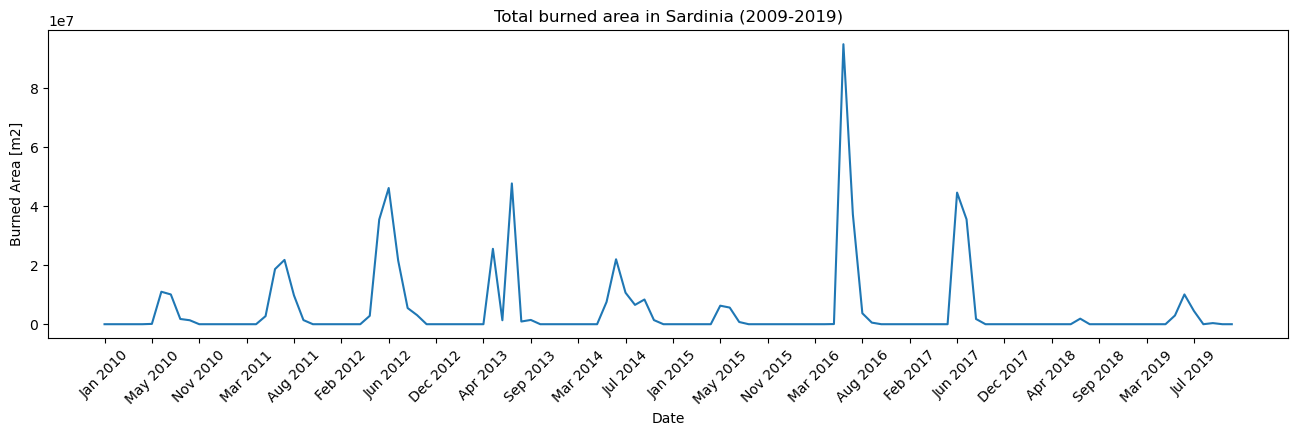

In [7]:
labels = np.asarray([f"{calendar.month_abbr[m]} {y}" for m,y in zip(db["month"],db["year"])])
ticks = np.linspace(0, len(labels), num=24, endpoint=False).astype('int')

plt.figure(figsize=(16,4))
plt.plot(total_burned_area)
plt.xlabel("Date")
plt.ylabel("Burned Area [m2]")
plt.xticks(ticks, labels[ticks], rotation=45)
_ = plt.title("Total burned area in Sardinia (2009-2019)")

In [8]:
print((db["lon"].min(),   db["lon"].max(),      
         db["lat"].min(), db["lat"].max()))

(8.125, 9.875, 38.875, 41.125)


In [9]:
dt = np.array(list(map(lambda x: datetime.datetime.strptime(str(x), '%Y%m'), db["idx"])))

In [12]:
BA_xr = xr.DataArray(burned_area.reshape(burned_area.shape[1], burned_area.shape[2], burned_area.shape[0]),
coords={'lat': np.array(db["lat"]),'lon': np.array(db["lon"]),'time': np.array(dt)}, 
dims=["lat", "lon", "time"])

In [13]:
BA_xr

<xarray.DataArray (lat: 10, lon: 8, time: 120)>
array([[[     0.,      0.,      0., ...,      0.,      0.,      0.],
        [     0.,      0.,      0., ...,      0.,      0.,      0.],
        [     0.,      0.,      0., ...,      0.,      0.,      0.],
        ...,
        [     0.,      0.,      0., ...,      0.,      0.,      0.],
        [     0.,      0.,      0., ...,      0.,      0.,      0.],
        [     0.,      0.,      0., ...,      0.,      0.,      0.]],

       [[     0.,      0.,      0., ...,      0.,      0.,      0.],
        [     0.,      0.,      0., ...,      0.,      0.,      0.],
        [     0.,      0.,      0., ...,      0.,      0.,      0.],
        ...,
        [     0.,      0.,      0., ...,      0.,      0.,      0.],
        [     0.,      0.,      0., ...,      0.,      0.,      0.],
        [     0.,      0.,      0., ...,      0.,      0.,      0.]],

       [[     0.,      0.,      0., ...,      0.,      0.,      0.],
        [     0.,      0.,      0., ...,      0.,      0.,      0.],
        [     0.,      0.,      0., ...,      0.,      0.,      0.],
        ...,
...
        [     0.,      0.,      0., ...,      0.,      0.,      0.],
        [     0.,      0.,      0., ...,      0.,      0.,      0.],
        [     0.,      0.,      0., ...,      0.,      0.,      0.]],

       [[     0.,      0.,      0., ...,      0.,      0.,      0.],
        [     0.,      0.,      0., ...,      0.,      0.,      0.],
        [     0.,      0.,      0., ...,      0.,      0.,      0.],
        ...,
        [     0.,      0.,      0., ...,      0.,      0.,      0.],
        [     0.,      0.,      0., ...,      0.,      0.,      0.],
        [     0.,      0.,      0., ...,      0.,      0.,      0.]],

       [[     0.,      0.,      0., ...,      0.,      0.,      0.],
        [     0.,      0.,      0., ...,      0.,      0.,      0.],
        [     0.,      0.,      0., ...,      0.,      0.,      0.],
        ...,
        [     0.,      0.,      0., ...,      0.,      0.,      0.],
        [     0.,      0.,      0., ...,      0.,      0.,      0.],
        [     0.,      0.,      0., ...,      0.,      0.,      0.]]],
      dtype=float32)
Coordinates:
  * lat      (lat) float64 41.12 40.88 40.62 40.38 ... 39.62 39.38 39.12 38.88
  * lon      (lon) float64 8.125 8.375 8.625 8.875 9.125 9.375 9.625 9.875
  * time     (time) datetime64[ns] 2010-01-01 2010-02-01 ... 2019-12-01

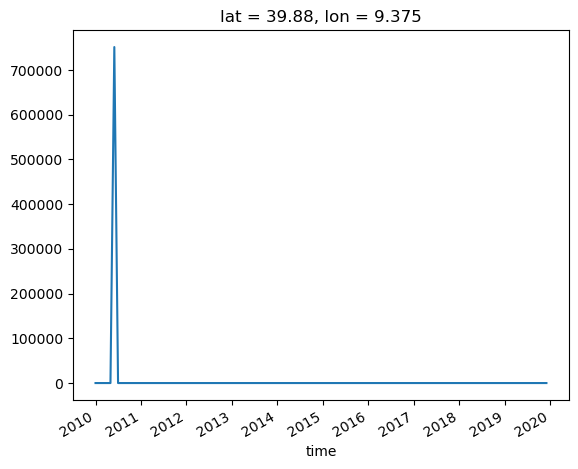

In [14]:
BA_xr.isel(lat=5, lon=5).plot()

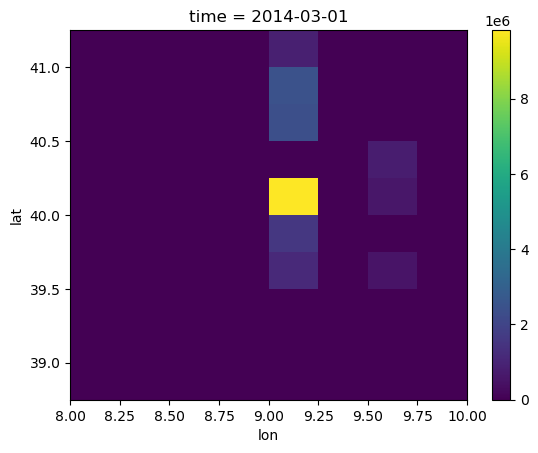

In [15]:
BA_xr.isel(time=50).plot()

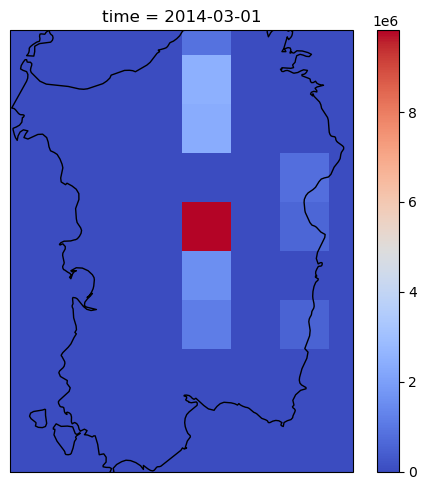

<Figure size 640x480 with 0 Axes>

In [48]:
ba0 = BA_xr.isel(time=50)
fig = plt.figure(figsize=(5,5), facecolor='w', edgecolor='k')

# Axes with Cartopy projection
ax = plt.axes(projection=ccrs.PlateCarree())
# and extent
ax.set_extent([8.125, 9.875, 38.875, 41.125], ccrs.PlateCarree())

cf = ba0.plot(transform=ccrs.PlateCarree(), cmap="coolwarm")
ax.coastlines(linewidth=1)

plt.tight_layout()
plt.show()
fig.clear()
plt.close(fig)
plt.clf()

In [55]:
t = BA_xr.isel(time=slice(0, 20, 3))

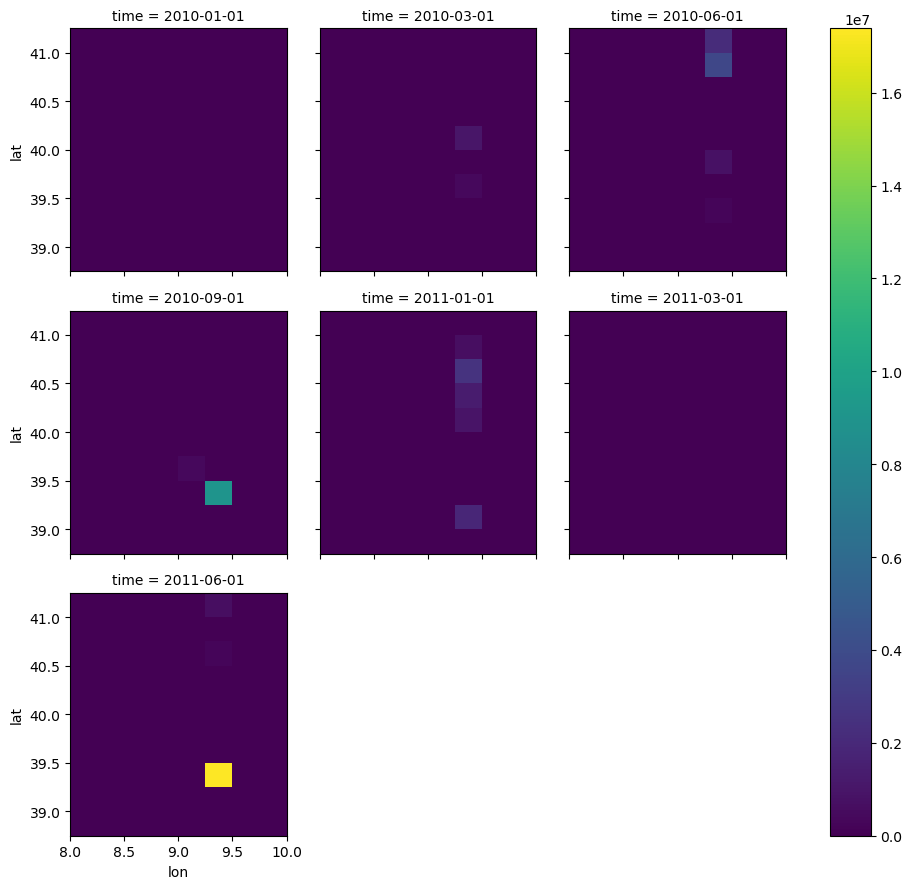

In [56]:
g_simple = t.plot(x='lon', y='lat', col='time', col_wrap=3)

## Ex: 

Play with xarray plotting. 


In [8]:
tr, lat, lon = burned_area[db['year']<2019,:,:].shape

In [9]:
te, _, _ = burned_area[db['year']==2019,:,:].shape

In [10]:
df_train = pd.DataFrame(data={'BA': list(burned_area[db['year']<2019,:,:].reshape(tr*lat*lon)), 
                              'frac_burnable': list(db['fraction_of_burnable_area'][db['year']<2019,:,:].reshape(tr*lat*lon)), 
                              't2m': list(db['t2m'][db['year']<2019,:,:].reshape(tr*lat*lon)), 
                              'tp': list(db['tp'][db['year']<2019,:,:].reshape(tr*lat*lon)), 
                              'u10': list(db['u10'][db['year']<2019,:,:].reshape(tr*lat*lon)), 
                              'v10': list(db['v10'][db['year']<2019,:,:].reshape(tr*lat*lon))})

In [11]:
df_test = pd.DataFrame(data={'BA': list(burned_area[db['year']==2019,:,:].reshape(te*lat*lon)), 
                              'frac_burnable': list(db['fraction_of_burnable_area'][db['year']==2019,:,:].reshape(te*lat*lon)), 
                              't2m': list(db['t2m'][db['year']==2019,:,:].reshape(te*lat*lon)), 
                              'tp': list(db['tp'][db['year']==2019,:,:].reshape(te*lat*lon)), 
                              'u10': list(db['u10'][db['year']==2019,:,:].reshape(te*lat*lon)), 
                              'v10': list(db['v10'][db['year']==2019,:,:].reshape(te*lat*lon))})

In [12]:
df_train.describe()

,BA,frac_burnable,t2m,tp,u10,v10
count,8.640000e+03,8640.000000,8640.000000,8640.000000,8640.000000,8640.000000
mean,6.476406e+04,0.488956,16.993549,1.619767,1.201992,-0.520912
std,8.718018e+05,0.419990,5.433089,1.429040,1.206081,0.938478
min,0.000000e+00,0.000000,2.826563,0.000000,-4.758626,-4.504514
25%,0.000000e+00,0.025713,12.548146,0.460470,0.449044,-1.051668
50%,0.000000e+00,0.407134,16.358755,1.245126,1.106653,-0.397740
75%,0.000000e+00,0.970423,21.991562,2.411773,1.875162,0.088269
max,5.028379e+07,0.996048,28.383447,8.465850,6.262784,2.924520


In [13]:
df_test.describe()

,BA,frac_burnable,t2m,tp,u10,v10
count,9.600000e+02,960.000000,960.000000,960.000000,960.000000,960.000000
mean,1.867082e+04,0.488730,17.227955,1.698534,1.301929,-0.634612
std,2.384247e+05,0.420001,5.821318,1.765040,1.162152,1.051100
min,0.000000e+00,0.000000,4.459741,0.005722,-1.247341,-4.509943
25%,0.000000e+00,0.025713,12.596005,0.501679,0.508939,-1.312796
50%,0.000000e+00,0.406687,15.581655,1.140561,1.151004,-0.541910
75%,0.000000e+00,0.969739,22.889468,2.499350,2.003513,0.032510
max,6.010442e+06,0.995329,27.331079,10.197497,6.156245,2.318494


In [14]:
df_train["target"] = df_train["BA"]
df_train["target"][df_train["BA"]>0] = 1
df_train["target"][df_train["BA"]==0] = 0

/var/folders/13/_v8w_7zn4vl2bf67fq08ppkw0000gn/T/ipykernel_14049/3009269931.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train["target"][df_train["BA"]>0] = 1
/var/folders/13/_v8w_7zn4vl2bf67fq08ppkw0000gn/T/ipykernel_14049/3009269931.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train["target"][df_train["BA"]==0] = 0


In [15]:
df_train["target"].value_counts()

0.0    8429
1.0     211
Name: target, dtype: int64

In [16]:
df_test["target"] = df_test["BA"]
df_test["target"][df_test["BA"]>0] = 1
df_test["target"][df_test["BA"]==0] = 0

/var/folders/13/_v8w_7zn4vl2bf67fq08ppkw0000gn/T/ipykernel_14049/870242724.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test["target"][df_test["BA"]>0] = 1
/var/folders/13/_v8w_7zn4vl2bf67fq08ppkw0000gn/T/ipykernel_14049/870242724.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test["target"][df_test["BA"]==0] = 0


In [17]:
df_test["target"].value_counts()

0.0    946
1.0     14
Name: target, dtype: int64

In [18]:
df_train.columns

Index(['BA', 'frac_burnable', 't2m', 'tp', 'u10', 'v10', 'target'], dtype='object')

<AxesSubplot: xlabel='t2m', ylabel='Density'>

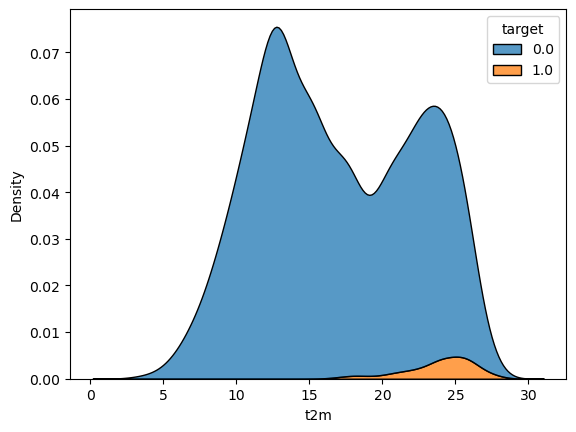

In [19]:
sns.kdeplot(data=df_train, x='t2m', hue="target", multiple="stack", common_norm=True)

In [20]:
X = df_train[['frac_burnable', 't2m', 'tp', 'u10', 'v10']]
y = df_train["target"]

In [21]:
scaler = StandardScaler()
scaler.fit(X)
X_n = scaler.transform(X)

In [22]:
X_test = df_test[['frac_burnable', 't2m', 'tp', 'u10', 'v10']]
y_test = df_test["target"]
X_testn = scaler.transform(X_test)

In [35]:
clf = DecisionTreeClassifier(criterion="entropy", max_depth=2, class_weight="balanced").fit(X_n, y)

In [36]:
print("accuracy = ", accuracy_score(y, clf.predict(X_n)))
print("F1 = ", f1_score(y, clf.predict(X_n)))
print("Precision = ", precision_score(y, clf.predict(X_n)))
print("Recall = ", recall_score(y, clf.predict(X_n)))

accuracy =  0.7795138888888888
F1 =  0.1742522756827048
Precision =  0.0958969465648855
Recall =  0.95260663507109


In [37]:
print("accuracy = ", accuracy_score(y_test, clf.predict(X_testn)))
print("F1 = ", f1_score(y_test, clf.predict(X_testn)))
print("Precision = ", precision_score(y_test, clf.predict(X_testn)))
print("Recall = ", recall_score(y_test, clf.predict(X_testn)))

accuracy =  0.7833333333333333
F1 =  0.1111111111111111
Precision =  0.05909090909090909
Recall =  0.9285714285714286


In [38]:
np.unique(clf.predict(X_n), return_counts=True)

(array([0., 1.], dtype=float32), array([6544, 2096]))

In [39]:
np.unique(y, return_counts=True)

(array([0., 1.], dtype=float32), array([8429,  211]))

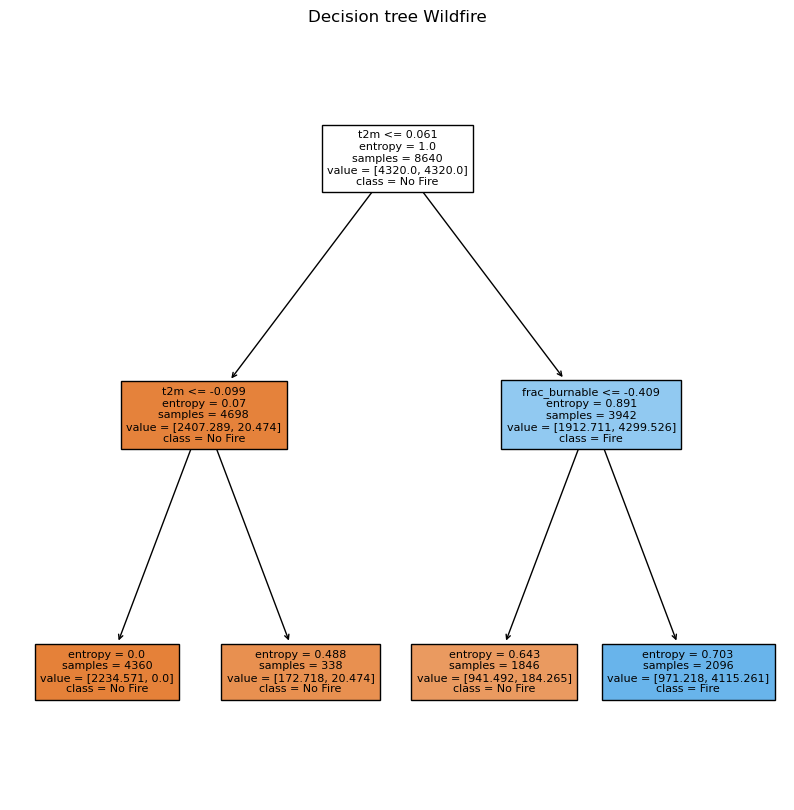

In [40]:
plt.figure(figsize=(10,10))
plot_tree(clf, filled=True, feature_names=X.columns, fontsize=8, class_names=["No Fire", "Fire"])
plt.title("Decision tree Wildfire")
plt.show()